In [9]:
#initialization
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pipeline import classify, reading, explore
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.learning_curve import validation_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, \
    precision_recall_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

filename = '~/Desktop/tothepipe_II.csv'
label = 'outcome_val'

In [10]:
df = reading.read(filename)

In [11]:
# Which are the features available to train our model?
explore.basics(df)

Observations:
567

164 features:
    1) Unnamed: 0
    2) Unnamed: 0.1
    3) Year of signing
    4) Month of signing
    5) fiscal_year
    6) major_sector
    7) procurement_category
    8) procurement_method
    9) procurement_type
    10) product_line
    11) project_name
    12) region
    13) supplier_country
    14) resolved_supplier
    15) borrower_country_std
    16) ppp
    17) currency_convert
    18) amount_of_contract (constant USD)
    19) amount_of contract (PPP)
    20) project_total_amount (PPP)
    21) contract as proportion of project
    22) country_mean_amount
    23) contract_high_rel__mean_by_year_flag
    24) country_total_amount
    25) contract_proportion__total_by_year
    26) objective
    27) competitive
    28) allegation_category
    29) outcome_val
    30) resolved_supplier_sum
    31) resolved_supplier_mean
    32) resolved_supplier_std
    33) resolved_supplier_sum_project
    34) resolved_supplier_mean_project
    35) resolved_supplier_std_project
  

In [12]:
#Notice the large values in some of the columns, might be useful to turn into log(x)
explore.desc_statistics(df)

Descriptive statistics:
               Unnamed: 0 Unnamed: 0.1 Year of signing Month of signing  \
count                 567          567             567              567   
mean                  283      520.228         2008.76          6.98589   
std               163.823      372.562         3.23815          3.20167   
min                     0            1            2001                1   
25%                 141.5        200.5            2007                4   
50%                   283          482            2009                7   
75%                 424.5        726.5            2012               10   
max                   566         1322            2014               12   
median                283          482            2009                7   
skew         -8.51797e-16     0.643274       -0.475513         -0.20888   
kurtosis             -1.2    -0.739026       -0.588777         -1.09202   
missing_vals            0            0               0                0   



In [13]:
# check for nulls in the dataset
for name in df.columns:
    if df[name].isnull().values.any():
        print(name)

objective
competitive
resolved_supplier_std
resolved_supplier_std_project
project_name_std
project_name_std_project


In [14]:
# if there are any nulls in "objective" and "competitive" columns, go for the conservative side and tag as False
have_nulls = ['objective','competitive']
for ft in have_nulls:
    df[ft] = df[ft].fillna('False')

# if there are any nulls in "xx_std" columns, means that there is only one observation, so assign standard deviation 
# of 1
std_nulls = ['resolved_supplier_std','resolved_supplier_std_project', 'project_name_std', 'project_name_std_project']
for ft in std_nulls:
    df[ft] = df[ft].fillna(0)

In [15]:
# turn booleans into 1's and 0's
have_bools = ['objective','competitive', 'contract_high_rel__mean_by_year_flag', 'outcome_val']
for ft in have_bools:
    df[ft] = df[ft].apply(lambda x: 1 if x else 0)

In [16]:
# For all features with categorical data, create integers referring to such values. This is in contrast to creating
# binary variables for all the possible values of these features. Notice that regression won't be as interpretable with
# this transformation, but methods such as decision trees and random forests might benefit from this categorization
# vs a binarization.
lb = preprocessing.LabelEncoder()
names = ['major_sector', 'product_line','region', 'supplier_country', 'resolved_supplier', 'borrower_country_std',\
         'allegation_category', 'procurement_type', 'procurement_method', 'procurement_category']
for name in names:
    keys = list(set(df[name].values))
    keys.sort()
    lb = preprocessing.LabelEncoder()
    lb.fit(keys)
    temp = lb.transform(df[name].values)
    df['{}_int'.format(name)] = temp
    df = df.drop(name, 1)

In [17]:
#delete unnecessary column
df = df.drop('project_name', 1)
df = df.drop('Unnamed: 0', 1)
df = df.drop('Unnamed: 0.1', 1)

In [18]:
# Transform features with very large integers using natural logarithm
names_w_large_nums = ['country_mean_amount', 'amount_of_contract (constant USD)', 'amount_of contract (PPP)', \
                      'project_total_amount (PPP)', 'country_total_amount']
for ft in names_w_large_nums:
    df[ft + " log"] = df[ft].apply(lambda x: math.log(x))
    df = df.drop(ft, 1)

In [19]:
#check new list of available features
fts = list(df.keys())
for i in range(len(fts)):
    if fts[i] == label:
        fts.pop(i)
        break
fts

['Year of signing',
 'Month of signing',
 'fiscal_year',
 'ppp',
 'currency_convert',
 'contract as proportion of project',
 'contract_high_rel__mean_by_year_flag',
 'contract_proportion__total_by_year',
 'objective',
 'competitive',
 'resolved_supplier_sum',
 'resolved_supplier_mean',
 'resolved_supplier_std',
 'resolved_supplier_sum_project',
 'resolved_supplier_mean_project',
 'resolved_supplier_std_project',
 'project_name_sum',
 'project_name_mean',
 'project_name_std',
 'project_name_sum_project',
 'project_name_mean_project',
 'project_name_std_project',
 'amount_of contract (PPP)+larger_average',
 'project_total_amount (PPP)+larger_average',
 'resolved_supplier_sum+larger_average',
 'resolved_supplier_sum_project+larger_average',
 'by_borrower_country_std_amount',
 'by_sector_amount',
 'by_year_amount',
 'by_cat_amount',
 'by_meth_amount',
 'by_type_amount',
 'by_borrower_country_std_resolved_supplier',
 'by_sector_resolved_supplier',
 'by_year_resolved_supplier',
 'by_cat_reso

In [12]:
# Separate data into test and train sets for further model validation. Training data will go through a model loop to
# identify models with good fit. Testing data will be used to validate generalization and prevent model overfitting.
xtrain, xtest, ytrain, ytest = train_test_split(df[fts], df[label])
len(xtrain), len(ytrain), len(xtest), len(ytest)

(425, 425, 142, 142)

In [13]:
# Define the set of models to be used in the loop, as well as a set of metrics to be recorded for every model.
#models = ['LR']
models = ['LR', 'KNN', 'DT', 'SVM', 'RF', 'GB']
metrics = ['precision', 'recall', 'roc_auc', 'f1']

In [14]:
lsvc = LinearSVC(C=.5, penalty="l1", dual=False).fit(xtrain, ytrain)
model = SelectFromModel(lsvc, prefit=True)
X = model.transform(xtrain)
X.shape

(425, 21)

In [15]:
fts = []
i=0
for name in xtrain.columns:
    if pd.DataFrame(model.inverse_transform(X))[i].sum() != 0 :
        fts.append(name)
    i += 1
fts.append('amount_of_contract (constant USD) log')

In [16]:
#df = df.drop('outcome_val', 1)
#df['outcome_val'][df['outcome_val'] == 1].count() / len(df) 

In [17]:
# Classifier threshold
u = 0.9
# thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
iters = 3

In [18]:
all_models = classify.classify(xtrain[fts], ytrain, models, iters, u, metrics)

LR


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Finished running LR
KNN
Finished running KNN
DT
Finished running DT
SVM
Finished running SVM
RF
Finished running RF
GB
Finished running GB


In [25]:
rv, best_models, bm = classify.select_best_models(all_models, models, 'precision_top_n')

DT {"{'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 1, 'criterion': 'gini'}": {'roc_auc': 0.47222222222222215, 'recall': 0.83333333333333337, 'precision_top_n': 0.875, 'time': 0.0066166718800862627, 'precision': 0.96200525175857254, 'f1': 0.888781745817674}, "{'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini'}": {'roc_auc': 0.491869918699187, 'recall': 0.98373983739837401, 'precision_top_n': 0.875, 'time': 0.0042736530303955078, 'precision': 0.96413890857547846, 'f1': 0.97380995584588403}, "{'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 1, 'criterion': 'gini'}": {'roc_auc': 0.5582655826558266, 'recall': 0.89430894308943076, 'precision_top_n': 0.875, 'time': 0.0042324066162109375, 'precision': 0.96945595139464247, 'f1': 0.92865249892372115}, "{'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 1, 'criterion': 'gini'}": {'roc_auc': 0.41260162601626016, 'recall': 0.82520325203252032, 'precision_top_n': 0.8000000000

In [22]:
all_models

{'DT': {"{'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 1, 'criterion': 'entropy'}": {'f1': 0.92783876691062306,
   'precision': 0.9603415559772297,
   'precision_top_n': 0.875,
   'recall': 0.90650406504065051,
   'roc_auc': 0.45325203252032525,
   'time': 0.004137674967447917},
  "{'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 1, 'criterion': 'gini'}": {'f1': 0.90114705230062742,
   'precision': 0.96271659049808023,
   'precision_top_n': 0.875,
   'recall': 0.85365853658536572,
   'roc_auc': 0.4823848238482385,
   'time': 0.0058446725209554034},
  "{'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy'}": {'f1': 0.95697621572489011,
   'precision': 0.96295152824945962,
   'precision_top_n': 0.875,
   'recall': 0.95121951219512191,
   'roc_auc': 0.47560975609756095,
   'time': 0.0043189525604248047},
  "{'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini'}": {'f1': 0.94168328475737584,

In [23]:
best_models

{'DT': {'metrics': {'f1': 0.888781745817674,
   'precision': 0.96200525175857254,
   'precision_top_n': 0.875,
   'recall': 0.83333333333333337,
   'roc_auc': 0.47222222222222215,
   'time': 0.0066166718800862627},
  'parameters': "{'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 1, 'criterion': 'gini'}"},
 'GB': {'metrics': {'f1': 0.98203592814371243,
   'precision': 0.96470588235294119,
   'precision_top_n': 0.875,
   'recall': 1.0,
   'roc_auc': 0.5,
   'time': 0.0049320062001546221},
  'parameters': "{'learning_rate': 0.1, 'n_estimators': 1, 'subsample': 1.0, 'max_depth': 1}"},
 'KNN': {'metrics': {'f1': 0.97590361445783136,
   'precision': 0.9642857142857143,
   'precision_top_n': 0.875,
   'recall': 0.98780487804878048,
   'roc_auc': 0.49390243902439024,
   'time': 0.005847056706746419},
  'parameters': "{'n_neighbors': 50, 'algorithm': 'kd_tree', 'weights': 'uniform'}"},
 'LR': {'metrics': {'f1': 0.93750000000000011,
   'precision': 0.96153846153846156,
   'precisio

In [29]:
name = bm[0][0]
params = bm[0][1]

In [31]:
# check if effectively performs well using the testing data
clf = RandomForestClassifier()
clf.set_params(**eval(best_models[name]['parameters']))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
yscores = clf.fit(xtrain[fts], ytrain).predict_proba(xtest[fts])[:,1]
xtest_temp = xtest.copy()
xtest_temp['yscore'] = yscores
xtest_temp['expected_value'] = xtest_temp['yscore'] * xtest_temp['amount_of_contract (constant USD) log']
xtest_temp = xtest_temp.sort_values(by='expected_value', ascending=False)

In [33]:
perc = 0.1
n = round(ytest.size * perc)
threshold = 0.9
yhat = np.asarray([1 if i >= threshold else 0 for i in xtest_temp['yscore']])
mtrs = classify.evaluate_classifier(ytest, yhat)
mtrs['precision_top_n'] = precision_score(ytest[:n], yhat[:n])

In [34]:
mtrs

{'accuracy': 0.92957746478873238,
 'f1': 0.96350364963503643,
 'precision': 0.97777777777777775,
 'precision_top_n': 1.0,
 'recall': 0.94964028776978415,
 'roc_auc': 0.47482014388489208}

In [32]:
# baseline for accuracy
ytest[ytest == 1].count() / len(ytest) 

0.99295774647887325

In [47]:
#Let's check if features can be reduced
X, y = xtrain.copy(), ytrain.copy()
X.shape

(425, 160)

In [43]:
lr = LogisticRegression().set_params(**eval(best_models['LR']['parameters'])).fit(X, y)
model = SelectFromModel(lr, prefit=True)
X_new = model.transform(X)
X_new.shape
fts=[]
i=0
for name in xtrain.columns:
    if pd.DataFrame(model.inverse_transform(X_new))[i].sum() != 0 :
        fts.append(name)
    i += 1
fts

['Year of signing', 'fiscal_year']

In [44]:
lsvc = LinearSVC(C=.5, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape
fts=[]
i=0
for name in xtrain.columns:
    if pd.DataFrame(model.inverse_transform(X_new))[i].sum() != 0 :
        fts.append(name)
    i += 1
fts

['Year of signing',
 'Month of signing',
 'fiscal_year',
 'ppp',
 'currency_convert',
 'ratio_by_borrower_country_std_amount',
 'ratio_by_year_amount',
 'ratio_by_meth_amount',
 'ratio_by_type_amount',
 'ratio_by_resolved_supplierc_amount',
 'diversification_resolved_supplier_project_name',
 'diversification_resolved_supplierc_project_name',
 'major_sector_int',
 'region_int',
 'supplier_country_int',
 'resolved_supplier_int',
 'borrower_country_std_int',
 'allegation_category_int',
 'procurement_type_int',
 'procurement_method_int',
 'project_total_amount (PPP) log']

In [49]:
svc = LassoCV().fit(X,y)
model = SelectFromModel(svc, prefit= True)
X_new = model.transform(X)
X_new.shape

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/feature_selection/base.py:80: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


(425, 0)

In [51]:
from sklearn.feature_selection import VarianceThreshold 
model = VarianceThreshold(threshold = .90)
X_new = model.fit_transform(X)
X_new.shape
fts=[]
i=0
for name in xtrain.columns:
    if pd.DataFrame(model.inverse_transform(X_new))[i].sum() != 0 :
        fts.append(name)
    i += 1
fts

['Year of signing',
 'Month of signing',
 'fiscal_year',
 'ppp',
 'currency_convert',
 'resolved_supplier_sum',
 'resolved_supplier_mean',
 'resolved_supplier_std',
 'resolved_supplier_sum_project',
 'resolved_supplier_mean_project',
 'resolved_supplier_std_project',
 'project_name_sum',
 'project_name_mean',
 'project_name_std',
 'project_name_sum_project',
 'project_name_mean_project',
 'ratio_by_borrower_country_std_amount',
 'ratio_by_sector_amount',
 'ratio_by_year_amount',
 'ratio_by_cat_amount',
 'ratio_by_meth_amount',
 'ratio_by_type_amount',
 'ratio_by_resolved_supplierc_amount',
 'diversification_resolved_supplier_major_sector',
 'diversification_resolved_supplier_country',
 'diversification_resolved_supplier_project_name',
 'diversification_resolved_supplierc_major_sector',
 'diversification_resolved_supplierc_borrower_country_std',
 'diversification_resolved_supplierc_project_name',
 'major_sector_int',
 'region_int',
 'supplier_country_int',
 'resolved_supplier_int',
 'bo

In [74]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge

In [30]:
np.random.seed(0)
iris = load_iris()
X, y = iris.data, iris.target
indices = np.arange(y.shape[0])
np.random.shuffle(indices)
X, y = X[indices], y[indices]

In [36]:
train_scores, valid_scores = validation_curve(Ridge(), X, y, "alpha",\
                                              np.logspace(-7, 3, 3))

In [37]:
train_scores

array([[ 0.94141575,  0.92944161,  0.92267644],
       [ 0.94141563,  0.92944153,  0.92267633],
       [ 0.47253778,  0.45601093,  0.42887489]])

In [38]:
valid_scores

array([[ 0.90335825,  0.92525985,  0.94159336],
       [ 0.90338529,  0.92523396,  0.94159078],
       [ 0.44639995,  0.39639757,  0.4567671 ]])

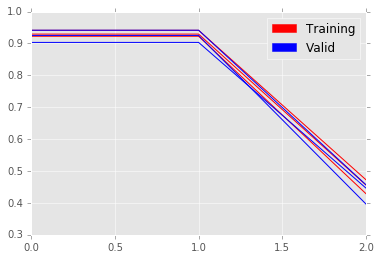

In [51]:
plt.plot(train_scores, color = 'red')
plt.plot(valid_scores, color = 'blue')
red_patch = mpatches.Patch(color='red', label='Training')
blue_patch = mpatches.Patch(color='blue', label='Valid')
plt.legend(handles=[red_patch, blue_patch])